In [1]:
#The following code is from Andrew Ng CNN Course
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops

def load_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches


def convert_to_one_hot(Y, C):
    #C - number of rows (here it will be the number of category)
    #Y - the category of the answer, will be in 2,1,2,3... and so on.
    #reshape - 1 means that it will make everything into 1d array
    #np.eye makes 2d array that set 1 for each diagonal, and set 0 otherwise
    #Using the [2], will generate 0 0 1 .....
    #Using the transpose we can make sure to make an array that has row for category and column for datapoints
    Y = (np.eye(C)[Y.reshape(-1)]).T
    return Y

C:\Users\Hp\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Hp\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Hp\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Hp\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1)

In [2]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops

%matplotlib inline
np.random.seed(1)

y = 2


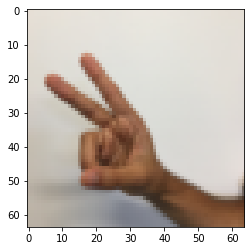

In [3]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()
# Example of a picture
index = 6
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [4]:
X_train = X_train_orig / 255
X_test = X_test_orig / 255
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [5]:
def createPlaceholders(nH0, nW0, nC0, nY):
    """
    Intent: This function will create the required placeholder for input and output when used inside the session
    
    Pre:
    nH0 = the number of the height for the pixel image input(also called layer 0)
    nW0 = the number of the width for the pixel image input(also called layer 0)
    nC0 = the number of the channel for the pixel image input(also called layer 0)
    nY = the number of the classes for the output
    
    Post:
    X = placeholder for the input, the first shape is set as None because we don't know the number of datapoints
    Y = placeholder for the output, the first shape is set as None because we don't know the number of the datapoints"""
    X = tf.placeholder(shape = [None, nH0, nW0, nC0], dtype = "float", name = "X")
    Y = tf.placeholder(shape = [None,nY], dtype = "float", name = "Y")
    return X,Y
    

In [6]:
X, Y = createPlaceholders(64, 64, 3, 6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("X:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Y:0", shape=(?, 6), dtype=float32)


In [7]:
def initializeParameters(parametersDims):
    """Initialize the w with the tf.contrib.xavier_initializer()
    
    Pre:
    parametersDims: 2d array: each of the 1d array has (nH, nW,nC_prev, nC)
    
    Post:
    parameters: dictionary of tensorflow variable that has been made"""
    tf.set_random_seed(1)   
    parameters = {}
    for i in range(len(parametersDims)):
        parameters[f"W{i+1}"] = tf.get_variable(f"W{i+1}", parametersDims[i], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    return parameters

In [8]:
tf.reset_default_graph()
parametersDims = [[4,4,3,8], [2,2,8,16]]
with tf.Session() as sess_test:
    parameters = initializeParameters(parametersDims)
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1[1,1,1] = \n" + str(parameters["W1"].eval()[1,1,1]))
    print("W1.shape: " + str(parameters["W1"].shape))
    print("\n")
    print("W2[1,1,1] = \n" + str(parameters["W2"].eval()[1,1,1]))
    print("W2.shape: " + str(parameters["W2"].shape))

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1[1,1,1] = 
[ 0.00131723  0.1417614  -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
W1.shape: (4, 4, 3, 8)


W2[1,1,1] = 
[-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]
W2.shape: (2, 2, 8, 16)


### 1.3 - Forward propagation

In TensorFlow, there are built-in functions that implement the convolution steps for you.

- **tf.nn.conv2d(X,W, strides = [1,s,s,1], padding = 'SAME'):** given an input $X$ and a group of filters $W$, this function convolves $W$'s filters on X. The third parameter ([1,s,s,1]) represents the strides for each dimension of the input (m, n_H_prev, n_W_prev, n_C_prev). Normally, you'll choose a stride of 1 for the number of examples (the first value) and for the channels (the fourth value), which is why we wrote the value as `[1,s,s,1]`. You can read the full documentation on [conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d).

- **tf.nn.max_pool(A, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME'):** given an input A, this function uses a window of size (f, f) and strides of size (s, s) to carry out max pooling over each window.  For max pooling, we usually operate on a single example at a time and a single channel at a time.  So the first and fourth value in `[1,f,f,1]` are both 1.  You can read the full documentation on [max_pool](https://www.tensorflow.org/api_docs/python/tf/nn/max_pool).

- **tf.nn.relu(Z):** computes the elementwise ReLU of Z (which can be any shape). You can read the full documentation on [relu](https://www.tensorflow.org/api_docs/python/tf/nn/relu).

- **tf.contrib.layers.flatten(P)**: given a tensor "P", this function takes each training (or test) example in the batch and flattens it into a 1D vector.  
    * If a tensor P has the shape (m,h,w,c), where m is the number of examples (the batch size), it returns a flattened tensor with shape (batch_size, k), where $k=h \times w \times c$.  "k" equals the product of all the dimension sizes other than the first dimension.
    * For example, given a tensor with dimensions [100,2,3,4], it flattens the tensor to be of shape [100, 24], where 24 = 2 * 3 * 4.  You can read the full documentation on [flatten](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/flatten).

- **tf.contrib.layers.fully_connected(F, num_outputs):** given the flattened input F, it returns the output computed using a fully connected layer. You can read the full documentation on [full_connected](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/fully_connected).

In the last function above (`tf.contrib.layers.fully_connected`), the fully connected layer automatically initializes weights in the graph and keeps on training them as you train the model. Hence, you did not need to initialize those weights when initializing the parameters.


#### Window, kernel, filter
The words "window", "kernel", and "filter" are used to refer to the same thing.  This is why the parameter `ksize` refers to "kernel size", and we use `(f,f)` to refer to the filter size.  Both "kernel" and "filter" refer to the "window."

In [17]:
def forwardPropagation(X,parameters, strideCNN, strideMaxpool, strideMaxF, outputNumber):
    """This function can execute forward propagation of CNN, and ended by fully connected layers.
    
    parameters:
    X = placeholder for input in shape of (input size, numOfExamples)
    parameters = dictionary tensor initialized before for each filter, with keys of W{number}
    strideCNN = stride from layer 1 until layer L of CNN
    strideMaxpool = stride from layer 1 until layer L of Maxpool
    strideMaxF = f size for max pooling
    outputNumber = number of category for the output
    
    return: 
    ZL = the ZL of last layer, which is after the fully connected and ready for the output"""
    
    L = len(parameters) #return number layer, for iteration of CNN
    cache = {} #the cache for Z and A
    
    cache["P0"] = X #let's just set X to P0 since we end every CNN process in P
    assert strideMaxF.shape == strideMaxpool.shape
    for i in range(L):
        cache[f"Z{i+1}"] = tf.nn.conv2d(cache[f"P{i}"], parameters[f"W{i+1}"], strides = [1, strideCNN[i], strideCNN[i], 1], padding = "SAME")
        cache[f"A{i+1}"] = tf.nn.relu(cache[f"Z{i+1}"])
        cache[f"P{i+1}"] = tf.nn.max_pool(cache[f"A{i+1}"], ksize = [1,strideMaxF[i], strideMaxF[i], 1], strides = [1,strideMaxpool[i], strideMaxpool[i], 1], padding = "SAME")
    
    #Flatting the layer
    F1 = tf.contrib.layers.flatten(cache[f"P{L}"])
    #use fully connected layer, usu tf.contrib.fully_connected(). leave the activation as none, we don't want to put softmax here, since the
    #softmax will be included when counting the loss function
    cache[f"ZFinal"] = tf.contrib.layers.fully_connected(F1, outputNumber, activation_fn = None)
    return cache[f"ZFinal"]

In [18]:
#This test case is from Andrew Ng Example
tf.reset_default_graph()
parametersDims = [[4,4,3,8], [2,2,8,16]]
strideCNN = [1,1] #stride from layer 1 until layer L of CNN, for now set to 1 and 1 only
strideMaxpool = np.array([8,4]) #stride from layer 1 until layer L of Maxpool, for now set to 8 and 4
strideMaxF = np.array([8,4]) #F size for max pooling
outputNumber = 6 #for now since we have 6 class
with tf.Session() as sess:
    np.random.seed(1)
    X, Y = createPlaceholders(64, 64, 3, 6)
    parameters = initializeParameters(parametersDims)
    Z3 = forwardPropagation(X, parameters, strideCNN, strideMaxpool, strideMaxF, outputNumber)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: np.random.randn(2,64,64,3), Y: np.random.randn(2,6)})
    print("Z3 = \n" + str(a))

Z3 = 
[[ 1.4416982  -0.24909668  5.4504995  -0.2618962  -0.20669872  1.3654671 ]
 [ 1.4070847  -0.02573182  5.08928    -0.4866991  -0.4094069   1.2624853 ]]


In [19]:
def computeCost(Z3, Y):
    """Compute the cost with softmax initializer
    
    Input: 
    Z3 = result of the last layer in the shape of (m, categoryNumber)
    Y = label of the correct output, same shape of Z3"""
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    return cost

In [20]:
#This testcase is from Andrew Ng
tf.reset_default_graph()
parametersDims = [[4,4,3,8], [2,2,8,16]]
strideCNN = [1,1] #stride from layer 1 until layer L of CNN, for now set to 1 and 1 only
strideMaxpool = np.array([8,4]) #stride from layer 1 until layer L of Maxpool, for now set to 8 and 4
strideMaxF = np.array([8,4]) #F size for max pooling
outputNumber = 6 #for now since we have 6 class
with tf.Session() as sess:
    np.random.seed(1)
    X, Y = createPlaceholders(64, 64, 3, 6)
    parameters = initializeParameters(parametersDims)
    Z3 = forwardPropagation(X, parameters, strideCNN, strideMaxpool, strideMaxF, outputNumber)
    cost = computeCost(Z3, Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, {X: np.random.randn(4,64,64,3), Y: np.random.randn(4,6)})
    print("cost = " + str(a))

cost = 4.664871


In [49]:
def model(X_train, Y_train, X_test, Y_test, parametersDims, strideCNN, strideMaxpool, strideMaxF, learningRate = 0.009, epochNums = 100, minibatchSize = 64, printCost = True):
    """Implement a CNN neural network with this order:
    CNN (repetition based on the number of parametersDims length)-> FC (regular NN ends with softmax)-> OUTPUT
    
    CNN sequence is as follows: Convolution -> ReLU -> Maxpool
    
    Input is as follows:
    X_train = numpy array for train dataset, in shape of (m, nH0, nW0, nC0)
    Y_train = numpy array for train result, in shape of (m, nY)
    X_test = numpy array for test ddataset, in shape of (m, nH, nW, nC)
    Y_test = numpy array for test result, in shape of (m, nY)
    parametersDims = 2d array: each of the 1d array has (nH, nW,nC_prev, nC)
    strideCNN = stride from layer 1 until layer L of CNN
    strideMaxpool = stride from layer 1 until layer L of Maxpool
    strideMaxF = f size for max pooling
    learningRate = the rate for AdamOptimizer, set 0.009 as default
    epochNums = for the number of rep, set 100 as default
    minibatchSize = the number of m inside each minibatch, set 64 as default
    printCost = print every 100 epochs
    
    Output:
    trainAccuracy = accuracy for train in float
    testAccuracy = accuracy for test in float
    parameters = trained parameters based on shape parametersDims"""
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, nH0, nW0, nC0) = X_train.shape             
    nY = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    #CREATING THE PATH
    #create placeholder
    X, Y = createPlaceholders(nH0, nW0, nC0, nY)
    #initialize parameters
    parameters = initializeParameters(parametersDims)
    #forward propagation
    ZL = forwardPropagation(X,parameters, strideCNN, strideMaxpool, strideMaxF, nY)
    #countingcost
    cost = computeCost(ZL, Y)
    #create the backprop
    gradOptimizer = tf.train.AdamOptimizer(learning_rate = learningRate).minimize(cost)
    
    init = tf.global_variables_initializer()
    #create the session
    with tf.Session() as sess:
        #intialize everything
        sess.run(init)
        
        #start the epoch
        for epoch in range(epochNums):
            #divide the minibatch first
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatchSize, seed)
            epochCost = 0
            for minibatch in minibatches:
                minibatchX, minibatchY = minibatch
                #run the session
                trash, minibatchCost = sess.run(fetches = [gradOptimizer, cost], feed_dict = {X: minibatchX, Y:minibatchY})
                
                #add the cost to the minibatchCost
                epochCost += minibatchCost
            
            #after done with everything, divide the epochCost with the total number of data
            epochCost /= m
            if printCost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epochCost))
            if printCost == True and epoch % 10 == 0:
                costs.append(epochCost)
                
        #Closing session, showing the plot
        plt.plot(np.squeeze(costs))
        plt.xlabel("Iteration every 10")
        plt.ylabel("Cost")
        plt.title(f"CNN with learning rate = {learningRate}")
        plt.show()

        #Calculate the correct number
        predictFinal = tf.argmax(ZL, axis = 1) #Find the max one, since we are using softmax
        correctPrediction = tf.equal(predictFinal, tf.argmax(Y,1)) #we use placeholder so that we can replace this with train/test set later

        #Calculate test set
        accuracy = tf.reduce_mean(tf.cast(correctPrediction, "float"))
        trainAccuracy = accuracy.eval(feed_dict = {X:X_train, Y:Y_train})
        testAccuracy = accuracy.eval(feed_dict = {X:X_test, Y:Y_test})
        print(f"Train Accuracy: {trainAccuracy}")
        print(f"Test Accuracy: {testAccuracy}")
        
        """
        #trying to count F1 score
        f1Score = tf.contrib.metrics.f1_score(Y, ZL)
        print(f1Score)
        f1Train = f1Score.eval(feed_dict = {X:X_train, Y:Y_train})
        f1Test = f1Score.eval(feed_dict = {X:X_test, Y:Y_test})
        print(f"F1 Score train: {f1Train}")
        print(f"F1 Score test: {f1Test}")
        """
        return trainAccuracy, testAccuracy, parameters

Cost after epoch 0: 0.028464
Cost after epoch 5: 0.028210
Cost after epoch 10: 0.028212
Cost after epoch 15: 0.028214
Cost after epoch 20: 0.028176
Cost after epoch 25: 0.026431
Cost after epoch 30: 0.024904
Cost after epoch 35: 0.023973
Cost after epoch 40: 0.023674
Cost after epoch 45: 0.023219
Cost after epoch 50: 0.023020
Cost after epoch 55: 0.022211
Cost after epoch 60: 0.021387
Cost after epoch 65: 0.018872
Cost after epoch 70: 0.017532
Cost after epoch 75: 0.016760
Cost after epoch 80: 0.016186
Cost after epoch 85: 0.015999
Cost after epoch 90: 0.015367
Cost after epoch 95: 0.014907


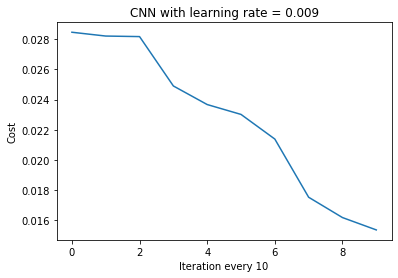

Train Accuracy: 0.6620370149612427
Test Accuracy: 0.5916666388511658


In [50]:
parametersDims = [[4,4,3,8], [2,2,8,16]]
strideCNN = [1,1] #stride from layer 1 until layer L of CNN, for now set to 1 and 1 only
strideMaxpool = np.array([8,4]) #stride from layer 1 until layer L of Maxpool, for now set to 8 and 4
strideMaxF = np.array([8,4]) #F size for max pooling
_, _, parameters = model(X_train, Y_train, X_test, Y_test, parametersDims, strideCNN, strideMaxpool, strideMaxF)

In [68]:
def predict(Xpredict, parameters, strideCNN, strideMaxpool, strideMaxF, nY):
    """use for predicting
    
    Input:
    Xpredict = Use for predicting testcase, in shape of (1, nH, nW, nC)
    parameters = trained parameters before
    strideCNN = stride from layer 1 until layer L of CNN
    strideMaxpool = stride from layer 1 until layer L of Maxpool
    strideMaxF = f size for max pooling
    nY = number of category for Y
    
    Output:
    predictCategory = output the possibleCategory
    """
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    Xpredict = np.array([Xpredict])
    (m, nH0, nW0, nC0) = Xpredict.shape
    #Create Path
    #Create placeholder
    print(Xpredict.shape)
    X, trash = createPlaceholders(nH0, nW0, nC0, nY)
    #ForwardProp
    ZL = forwardPropagation(X,parameters, strideCNN, strideMaxpool, strideMaxF, nY)
    
    finalY = tf.argmax(ZL, 1)
    session.run(finalY)
    return finalY

In [69]:
strideCNN = [1,1] #stride from layer 1 until layer L of CNN, for now set to 1 and 1 only
strideMaxpool = np.array([8,4]) #stride from layer 1 until layer L of Maxpool, for now set to 8 and 4
strideMaxF = np.array([8,4]) #F size for max pooling
nY = Y_train.shape[1]
parameters = predict(X_train[0], parameters, strideCNN, strideMaxpool, strideMaxF, nY)

1
(1, 64, 64, 3)


ValueError: Tensor("W1:0", shape=(4, 4, 3, 8), dtype=float32_ref) must be from the same graph as Tensor("X:0", shape=(?, 64, 64, 3), dtype=float32).